In [0]:
import numpy as np
import time, math
from tqdm import tqdm_notebook as tqdm

import tensorflow as tf
import tensorflow.contrib.eager as tfe
import matplotlib.pyplot as plt

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [0]:
tf.enable_eager_execution()


In [0]:
BATCH_SIZE = 512 #@param {type:"integer"}
MOMENTUM = 0.85 #@param {type:"number"}
LEARNING_RATE = 0.4 #@param {type:"number"}
WEIGHT_DECAY = 5e-4 #@param {type:"number"}
EPOCHS = 24 #@param {type:"integer"}

In [0]:
def init_pytorch(shape, dtype=tf.float32, partition_info=None):
  fan = np.prod(shape[:-1])
  bound = 1 / math.sqrt(fan)
  return tf.random.uniform(shape, minval=-bound, maxval=bound, dtype=dtype)

In [0]:
class ConvBN(tf.keras.Model):
  def __init__(self, c_out):
    super().__init__()
    self.conv = tf.keras.layers.Conv2D(filters=c_out, kernel_size=3, padding="SAME", kernel_initializer=init_pytorch, use_bias=False)
    self.bn = tf.keras.layers.BatchNormalization(momentum=0.9, epsilon=1e-5)

  def call(self, inputs):
    return tf.nn.relu(self.bn(self.conv(inputs)))

In [0]:
class ResBlk(tf.keras.Model):
  def __init__(self, c_out, pool, res = False):
    super().__init__()
    self.conv_bn = ConvBN(c_out)
    self.pool = pool
    self.res = res
    if self.res:
      self.res1 = ConvBN(c_out)
      self.res2 = ConvBN(c_out)

  def call(self, inputs):
    h = self.pool(self.conv_bn(inputs))
    if self.res:
      h = h + self.res2(self.res1(h))
    return h

In [0]:
class DavidNet(tf.keras.Model):
  def __init__(self, c=64, weight=0.125):
    super().__init__()
    pool = tf.keras.layers.MaxPooling2D()
    self.init_conv_bn = ConvBN(c)
    self.blk1 = ResBlk(c*2, pool, res = True)
    self.blk2 = ResBlk(c*4, pool)
    self.blk3 = ResBlk(c*8, pool, res = True)
    self.pool = tf.keras.layers.GlobalMaxPool2D()
    self.linear = tf.keras.layers.Dense(10, kernel_initializer=init_pytorch, use_bias=False)
    self.weight = weight

  def call(self, x, y):
    h = self.pool(self.blk3(self.blk2(self.blk1(self.init_conv_bn(x)))))
    h = self.linear(h) * self.weight
    ce = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=h, labels=y)
    loss = tf.reduce_sum(ce)
    correct = tf.reduce_sum(tf.cast(tf.math.equal(tf.argmax(h, axis = 1), y), tf.float32))
    return loss, correct

In [0]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
len_train, len_test = len(x_train), len(x_test)
y_train = y_train.astype('int64').reshape(len_train)
y_test = y_test.astype('int64').reshape(len_test)

train_mean = np.mean(x_train, axis=(0,1,2))
train_std = np.std(x_train, axis=(0,1,2))

normalize = lambda x: ((x - train_mean) / train_std).astype('float32') # todo: check here
pad4 = lambda x: np.pad(x, [(0, 0), (4, 4), (4, 4), (0, 0)], mode='reflect')

x_train = normalize(pad4(x_train))
x_test = normalize(x_test)

170500096/170498071 [==============================] - 2s 0us/step


In [0]:
def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def tf_example_protocol(image, label):
    feature_dict = {
        'image': _bytes_feature(image.tostring()),
        'label': _int64_feature(label),
    }

    features = tf.train.Features(feature=feature_dict)
    tf_example = tf.train.Example(features=features)
    protocol = tf_example.SerializeToString()

    return protocol

def convert_protocol_to_image(protocol_message):
    feature_dict = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'label': tf.io.FixedLenFeature([], tf.int64)
    }

    parsed_out = tf.io.parse_single_example(serialized=protocol_message,
                                            features=feature_dict)
    
    image = tf.io.decode_raw(parsed_out['image'], out_type=tf.float32)
    label = parsed_out["label"]
    
    return (image,label)
    
def convert_np_to_tfrecords(images, labels,filename=None):
    # Converts a numpy array into TFReocrds
    if filename == None:
        filename = 'dataset.tfrecords'
    with tf.io.TFRecordWriter(filename) as writer:
        for img,label in zip(images,labels):
            protocol_message = tf_example_protocol(img,label)
            writer.write(protocol_message)

In [0]:
convert_np_to_tfrecords(x_train, y_train,filename='train.tfrecords')
convert_np_to_tfrecords(x_test, y_test, filename='test.tfrecords')


In [0]:
def input_foo(filenames, buffer_size = 8*1024, seed = 50, batch_size = 128):
  dataset = tf.data.TFRecordDataset(filenames=filenames, buffer_size=buffer_size)
  dataset = dataset.map(convert_protocol_to_image)
  if filenames == 'test.tfrecords':
    dataset = dataset.map(lambda x, y: (tf.reshape(x,[32,32,3]), y))
  else:
    dataset = dataset.map(lambda x, y: (tf.reshape(x,[40,40,3]), y))
  dataset = dataset.apply(tf.data.experimental.prefetch_to_device('/GPU:0'))
  dataset = dataset.prefetch(4)
  return dataset

In [0]:
test_dataset = input_foo(filenames='test.tfrecords')
train_dataset = input_foo(filenames='train.tfrecords')

In [0]:
def replace_slice(input_: tf.Tensor, replacement, begin) -> tf.Tensor:
    inp_shape = tf.shape(input_)
    size = tf.shape(replacement)
    padding = tf.stack([begin, inp_shape - (begin + size)], axis=1)
    replacement_pad = tf.pad(replacement, padding)
    mask = tf.pad(tf.ones_like(replacement, dtype=tf.bool), padding)
    return tf.where(mask, replacement_pad, input_)


def get_cutout_eraser(minimum, maximum, area: int = 81, c: int = 3, min_aspect_ratio=0.5, max_aspect_ratio=1 / 0.5):
    sqrt_area = np.sqrt(area)

    def get_h_w(aspect_ratio):
        h = sqrt_area / aspect_ratio
        w = tf.math.round(area / h)
        h = tf.math.round(h)
        h = tf.cast(h, tf.int32)
        w = tf.cast(w, tf.int32)
        return h, w

    def tf_cutout(x: tf.Tensor) -> tf.Tensor:
        """
        Cutout data augmentation. Randomly cuts a h by w whole in the image, and fill the whole with zeros.
        :param x: Input image.
        :param h: Height of the hole.
        :param w: Width of the hole
        :param c: Number of color channels in the image. Default: 3 (RGB).
        :return: Transformed image.
        """
        p_1 = np.random.rand()
        if p_1 > 0.5:
          return x
        
        dtype = x.dtype
        minval = tf.cast(minimum, dtype=dtype)
        maxval = tf.cast(maximum, dtype=dtype)

        aspect_ratio = tf.random.uniform([], min_aspect_ratio, max_aspect_ratio)
        h, w = get_h_w(aspect_ratio)

        shape = tf.shape(x)
        x0 = tf.random.uniform([], 0, shape[0] + 1 - h, dtype=tf.int32)
        y0 = tf.random.uniform([], 0, shape[1] + 1 - w, dtype=tf.int32)

        img_mean = tf.reduce_mean(x)
        
        # find cut portion mean instead of whole mean

        slic = tf.fill([h, w, c], img_mean)

        x = replace_slice(x, slic, [x0, y0, 0])
        return x

    return tf_cutout
    
cutout = get_cutout_eraser(0,255)


In [0]:
lr = []
ep = []
trainAcc = []
testAcc = []
mt = []

In [0]:
model = DavidNet()
batches_per_epoch = len_train//BATCH_SIZE + 1

schedule = np.interp(np.arange(EPOCHS+1), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.76), EPOCHS], [LEARNING_RATE*0.15, LEARNING_RATE, LEARNING_RATE*0.05, 0.001]) 
lr_schedule = lambda t: schedule[t]

m_schedule = np.interp(np.arange(EPOCHS+1), [0, int((EPOCHS+1)*0.2), int((EPOCHS+1)*0.76), EPOCHS], [MOMENTUM*1.01, MOMENTUM*0.91, MOMENTUM, MOMENTUM]) 
moment_schedule = lambda mt: m_schedule[mt]

global_step = tf.train.get_or_create_global_step()

lr_func = lambda: lr_schedule(global_step/batches_per_epoch)/BATCH_SIZE
moment_func = lambda: moment_schedule(global_step/batches_per_epoch)/BATCH_SIZE

opt = tf.train.MomentumOptimizer(lr_func, momentum=moment_func, use_nesterov=True)

data_aug = lambda x, y: (cutout(tf.image.random_flip_left_right(tf.random_crop(x, [32, 32, 3]))), y)

In [0]:
t = time.time()
test_set = test_dataset.batch(BATCH_SIZE)

for epoch in range(EPOCHS):

  lr_ep = lr_schedule(epoch+1)
  lr.append(lr_ep)
  mt_ep = moment_schedule(epoch+1)
  mt.append(mt_ep)

  train_loss = test_loss = train_acc = test_acc = 0.0
  train_set = train_dataset.map(data_aug).shuffle(len_train).batch(BATCH_SIZE).prefetch(1)

  tf.keras.backend.set_learning_phase(1)
  for (x, y) in tqdm(train_set):
    with tf.GradientTape() as tape:
      loss, correct = model(x, y)

    var = model.trainable_variables
    grads = tape.gradient(loss, var)
    for g, v in zip(grads, var):
      g += v * WEIGHT_DECAY * BATCH_SIZE
    opt.apply_gradients(zip(grads, var), global_step=global_step)

    train_loss += loss.numpy()
    train_acc += correct.numpy()

  tf.keras.backend.set_learning_phase(0)
  for (x, y) in test_set:
    loss, correct = model(x, y)
    test_loss += loss.numpy()
    test_acc += correct.numpy()
  
  testAcc.append(test_acc / len_test)
  trainAcc.append(train_acc / len_train)
  ep.append(epoch+1)  
  print('epoch:', epoch+1, 'lr:', lr_schedule(epoch+1), 'train loss:', train_loss / len_train, 'train acc:', train_acc / len_train, 'val loss:', test_loss / len_test, 'val acc:', test_acc / len_test, 'time:', time.time() - t)


epoch: 1 lr: 0.128 train loss: 1.726948430786133 train acc: 0.3966 val loss: 1.4103490509033203 val acc: 0.5042 time: 48.76225543022156
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



epoch: 2 lr: 0.196 train loss: 1.3972602740478515 train acc: 0.49114 val loss: 1.1888918823242187 val acc: 0.5639 time: 88.95111608505249



epoch: 3 lr: 0.264 train loss: 1.1095731982421875 train acc: 0.59856 val loss: 1.0385405181884766 val acc: 0.6313 time: 123.42669320106506



epoch: 4 lr: 0.332 train loss: 0.9300289971923829 train acc: 0.66972 val loss: 1.0392637298583984 val acc: 0.6429 time: 157.72032141685486



epoch: 5 lr: 0.4 train loss: 0.8028758627319336 train acc: 0.71956 val loss: 0.8740026458740234 val acc: 0.6967 time: 192.5666425228119



epoch: 6 lr: 0.3728571428571429 train loss: 0.8696302026367188 train acc: 0.70136 val loss: 0.6455992401123047 val acc: 0.7798 time: 231.8419849872589



epoch: 7 lr: 0.34571428571428575 train loss: 0.6521735137939453 train acc: 0.77468 val loss: 0.5446542541503906 val acc: 0.8156 time: 271.18796825408936



epoch: 8 lr: 0.3185714285714286 train loss: 0.46471415802001953 train acc: 0.84066 val loss: 0.5454762664794922 val acc: 0.8139 time: 305.7131016254425



epoch: 9 lr: 0.2914285714285715 train loss: 0.40124429931640626 train acc: 0.86208 val loss: 0.4336526504516602 val acc: 0.8506 time: 340.76002740859985



epoch: 10 lr: 0.26428571428571435 train loss: 0.3546088777160645 train acc: 0.8775 val loss: 0.5418555938720703 val acc: 0.8242 time: 375.10859537124634



epoch: 11 lr: 0.23714285714285716 train loss: 0.43483810638427733 train acc: 0.84972 val loss: 0.46631253051757815 val acc: 0.8409 time: 414.3053889274597



epoch: 12 lr: 0.21000000000000002 train loss: 0.2935575778198242 train acc: 0.90056 val loss: 0.4062963653564453 val acc: 0.8597 time: 448.20109128952026



epoch: 13 lr: 0.18285714285714288 train loss: 0.36502580139160157 train acc: 0.87326 val loss: 0.49410139923095703 val acc: 0.8409 time: 487.355993270874



epoch: 14 lr: 0.15571428571428575 train loss: 0.24416489471435546 train acc: 0.91794 val loss: 0.36307744522094726 val acc: 0.8715 time: 521.6652746200562



epoch: 15 lr: 0.12857142857142861 train loss: 0.2153903291320801 train acc: 0.92902 val loss: 0.32310878143310545 val acc: 0.8871 time: 556.4592719078064



epoch: 16 lr: 0.10142857142857148 train loss: 0.19409964378356934 train acc: 0.9365 val loss: 0.2916992034912109 val acc: 0.9002 time: 591.2116918563843



epoch: 17 lr: 0.07428571428571429 train loss: 0.27004526382446287 train acc: 0.90608 val loss: 0.3517932746887207 val acc: 0.8807 time: 629.8354847431183



epoch: 18 lr: 0.04714285714285715 train loss: 0.24980353179931641 train acc: 0.91522 val loss: 0.38943771743774414 val acc: 0.8728 time: 669.1606917381287



epoch: 19 lr: 0.020000000000000004 train loss: 0.15242736328125 train acc: 0.95288 val loss: 0.2647504608154297 val acc: 0.9102 time: 703.967132806778



epoch: 20 lr: 0.016200000000000003 train loss: 0.14030559509277343 train acc: 0.9561 val loss: 0.26028263473510743 val acc: 0.9119 time: 737.5723474025726



epoch: 21 lr: 0.012400000000000003 train loss: 0.13611336135864258 train acc: 0.95818 val loss: 0.25585301666259763 val acc: 0.9127 time: 772.024876832962



epoch: 22 lr: 0.008600000000000003 train loss: 0.21195998260498047 train acc: 0.92906 val loss: 0.26344847946166994 val acc: 0.912 time: 810.6064474582672



epoch: 23 lr: 0.004800000000000002 train loss: 0.13228405410766603 train acc: 0.9593 val loss: 0.25476169242858887 val acc: 0.9134 time: 845.0995743274689



epoch: 24 lr: 0.001 train loss: 0.20778582427978515 train acc: 0.93048 val loss: 0.2605095478057861 val acc: 0.9129 time: 883.4777386188507


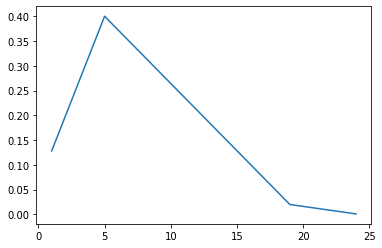

In [0]:
plt.plot(ep, lr)

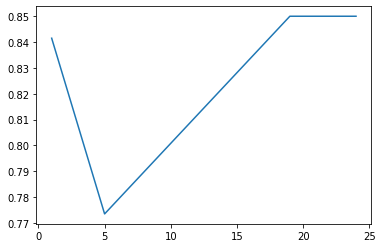

In [0]:
plt.plot(ep, mt)

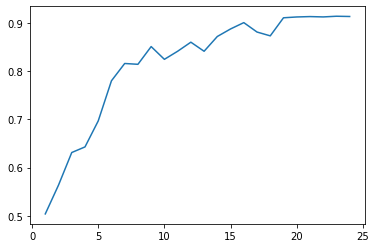

In [0]:
plt.plot(ep, testAcc)

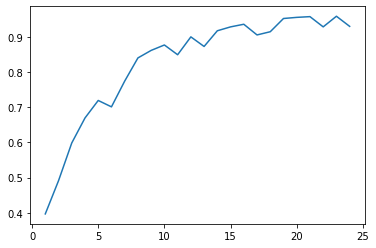

In [0]:
plt.plot(ep, trainAcc)